In [ ]:
# --- 1. Thư viện cần thiết ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.arima.model import ARIMA
from darts.models import NBEATSModel
from darts import TimeSeries
warnings.filterwarnings("ignore")

# --- 2. Đọc và phân tích dữ liệu gốc ---
df = pd.read_csv(r"C:\Users\nguye\CODE\TimeSeries\BTL\Thang10_Thang11\User\2019_Data_Cleaned.csv", parse_dates=['event_time'])
df['date'] = df['event_time'].dt.date

# Kiểm tra mất cân bằng nhãn churn
churn_counts = df['churn'].value_counts()
print("\nTổng quan nhãn churn:")
print(churn_counts)
print("\nTỷ lệ churn:", churn_counts[1] / churn_counts.sum())


Tổng quan nhãn churn:
churn
0    1271593
1    1215607
Name: count, dtype: int64

Tỷ lệ churn: 0.4887451752975233


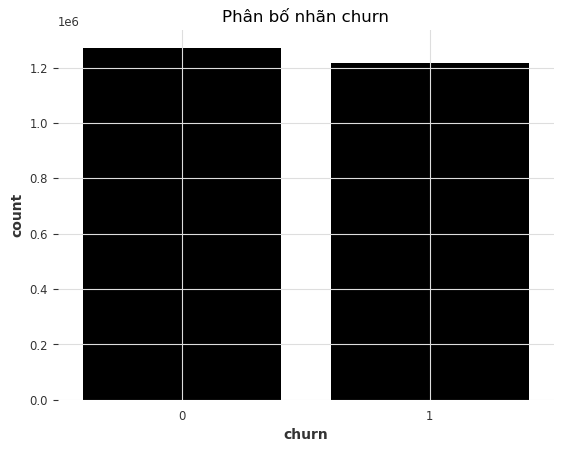

In [2]:
# Vẽ biểu đồ nhãn churn
sns.countplot(x='churn', data=df)
plt.title("Phân bố nhãn churn")
plt.grid(True)
plt.show()

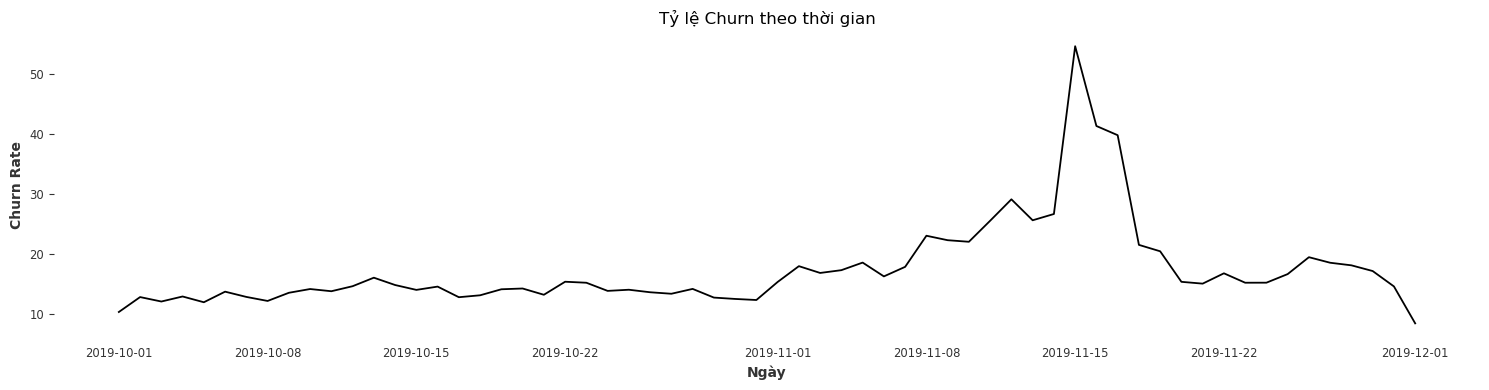

In [3]:
# --- 3. Tính churn_rate theo ngày ---
df['date'] = pd.to_datetime(df['date'])
daily_stats = df.groupby('date').agg(
    total_users=('user_id', 'nunique'),
    churned_users=('churn', 'sum')
).reset_index()
daily_stats['churn_rate'] = daily_stats['churned_users'] / daily_stats['total_users']

# Bỏ các ngày có quá ít người dùng (dưới 10)
daily_stats = daily_stats[daily_stats['total_users'] >= 10]

# Bổ sung các ngày bị thiếu trong chuỗi thời gian
all_dates = pd.date_range(start=daily_stats['date'].min(), end=daily_stats['date'].max())
daily_stats = daily_stats.set_index('date').reindex(all_dates).fillna(method='ffill')
daily_stats.index.name = 'date'

# Biểu đồ churn_rate theo thời gian
plt.figure(figsize=(15,4))
plt.plot(daily_stats.index, daily_stats['churn_rate'], label='Churn Rate')
plt.title("Tỷ lệ Churn theo thời gian")
plt.xlabel("Ngày")
plt.ylabel("Churn Rate")
plt.grid()
plt.tight_layout()
plt.show()

In [4]:
# --- 4. Tạo tập train/test ---
series = daily_stats['churn_rate']
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

In [5]:
# --- 5. ARIMA ---
model_arima = ARIMA(train, order=(5,1,0))
model_fit = model_arima.fit()
pred_arima = model_fit.forecast(steps=len(test))

In [6]:
# --- 6. LSTM ---
scaler_min = train.min()
scaler_max = train.max()
scaled_train = (train - scaler_min) / (scaler_max - scaler_min)
scaled_test = (test - scaler_min) / (scaler_max - scaler_min)

def create_lstm_dataset(series, look_back=7):
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back])
    return np.array(X), np.array(y)

look_back = 7
X_train_lstm, y_train_lstm = create_lstm_dataset(scaled_train.values, look_back)
X_test_lstm, y_test_lstm = create_lstm_dataset(scaled_test.values, look_back)
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, verbose=0)
pred_lstm = model_lstm.predict(X_test_lstm)
pred_lstm = pred_lstm.flatten() * (scaler_max - scaler_min) + scaler_min

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


In [7]:
# --- 7. N-BEATS ---
series_darts = TimeSeries.from_series(series)
train_darts, test_darts = series_darts.split_after(train_size)
model_nbeats = NBEATSModel(input_chunk_length=30, output_chunk_length=7, n_epochs=100, random_state=0)
model_nbeats.fit(train_darts)
pred_nbeats = model_nbeats.predict(len(test_darts))
pred_series = pred_nbeats.to_series()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 6.2 M  | train
-------------------------------------------------------------
6.2 M     Trainable params
1.5 K     Non-trainable params
6.2 M     Total params
24.972    Total estimated model params size (MB)
396       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [8]:
# Hàm đánh giá
def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"\n{model_name}:")
    print(f"MAE: {mae:.5f}")
    print(f"RMSE: {rmse:.5f}")
    print(f"MAPE: {mape:.2f}%")

# Giả sử test, pred_arima, pred_lstm, pred_nbeats đã có trong môi trường

# Chuyển pred_nbeats sang numpy array
pred_nbeats_np = pred_nbeats.values()

# Cắt test cho khớp chiều với pred_nbeats
if isinstance(test, np.ndarray):
    y_true_nbeats = test[-len(pred_nbeats_np):]
elif hasattr(test, 'values'):  # pandas Series
    y_true_nbeats = test.values[-len(pred_nbeats_np):]
else:
    raise TypeError("Kiểu dữ liệu của 'test' chưa được hỗ trợ.")

# Cắt test cho khớp chiều với pred_arima
if isinstance(test, np.ndarray):
    y_true_arima = test[:len(pred_arima)]
elif hasattr(test, 'values'):
    y_true_arima = test.values[:len(pred_arima)]
else:
    raise TypeError("Kiểu dữ liệu của 'test' chưa được hỗ trợ.")

# Cắt test cho khớp chiều với pred_lstm
if isinstance(test, np.ndarray):
    y_true_lstm = test[look_back:look_back+len(pred_lstm)]
elif hasattr(test, 'values'):
    y_true_lstm = test.values[look_back:look_back+len(pred_lstm)]
else:
    raise TypeError("Kiểu dữ liệu của 'test' chưa được hỗ trợ.")

# Gọi hàm evaluate cho từng mô hình
evaluate(y_true_arima, pred_arima, "ARIMA")
evaluate(y_true_lstm, pred_lstm, "LSTM")
evaluate(y_true_nbeats, pred_nbeats_np, "N-BEATS")



ARIMA:
MAE: 20.60493
RMSE: 21.33207
MAPE: 137.39%

LSTM:
MAE: 3.45319
RMSE: 5.12603
MAPE: 32.01%

N-BEATS:
MAE: 44.23016
RMSE: 53.03508
MAPE: 295.33%


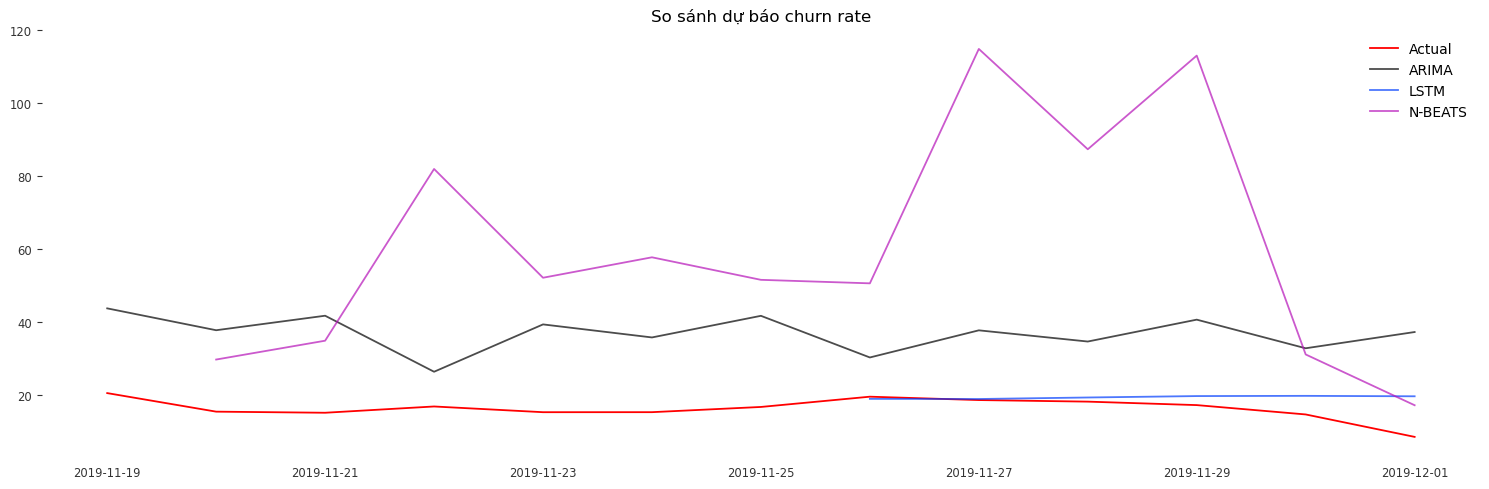

In [13]:
plt.figure(figsize=(15,5))

# Vẽ dữ liệu thực tế
plt.plot(test.index, test, label="Actual", color='red')

# Vẽ dự báo ARIMA, cắt index cho khớp chiều
plt.plot(test.index[:len(pred_arima)], pred_arima, label="ARIMA", alpha=0.7)

# Vẽ dự báo LSTM, cắt index theo look_back và độ dài dự báo
plt.plot(test.index[look_back:look_back+len(pred_lstm)], pred_lstm, label="LSTM", alpha=0.7)

# Vẽ dự báo N-BEATS với time_index và giá trị
plt.plot(pred_nbeats.time_index, pred_nbeats.values(), label="N-BEATS", alpha=0.7)

plt.legend()
plt.title("So sánh dự báo churn rate")
plt.grid()
plt.tight_layout()
plt.show()
